In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import  tqdm

import mne
mne.set_log_level(verbose=False)

from Datasets import *
import utils

In [2]:
channels = ["C3", "C4", "O1", "O2", "A1", "A2", "LOC", "ROC", "LAT1", "LAT2", "RAT1", "RAT2", "CHIN1", "CHIN2"]

In [27]:
data = mne.io.read_raw_edf("../Data/PSG1.edf")
dataset = EDFData("../Data/PSG1.edf", channels=channels)

In [28]:
dataset.epochs.set_channel_types({
    "LAT1":"eog",
    "LAT2":"eog",
    "RAT1":"eog",
    "RAT2":"eog",
    "CHIN1":"emg",
    "CHIN2":"emg"
})

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


## Same threshold for same type channels

In [5]:
from autoreject import get_rejection_threshold

In [6]:
reject = get_rejection_threshold(dataset.epochs, decim=2)

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


In [29]:
reject

{'eeg': 0.0008236575875486381, 'eog': 0.0018925337605859463}

In [30]:
dataset.epochs.drop_bad(reject=reject)


Number of events,573
Events,Sleep stage N1: 17Sleep stage N2: 240Sleep stage N3: 153Sleep stage R: 76Sleep stage W: 87
Time range,0.000 – 29.998 sec
Baseline,off


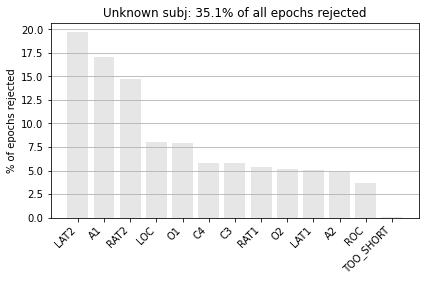

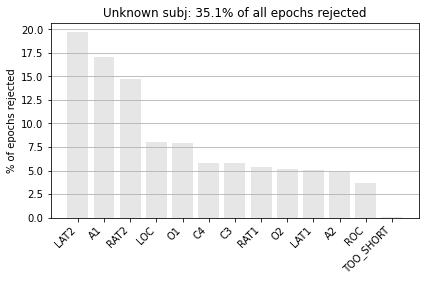

In [9]:
dataset.epochs.plot_drop_log()

## Threshold per channel

In [10]:
from autoreject import compute_thresholds

In [11]:
dataset = EDFData("../Data/PSG1.edf", channels=channels)

In [12]:
dataset.epochs.set_channel_types({
    "LAT1":"eog",
    "LAT2":"eog",
    "RAT1":"eog",
    "RAT2":"eog",
    "CHIN1":"emg",
    "CHIN2":"emg"
})

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [13]:
dataset.epochs.load_data() # Has to be preloaded

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [14]:
montage = mne.channels.make_standard_montage('standard_alphabetic')
montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 65 channels>

In [15]:
channels_not_in_montage = [ch for ch in dataset.epochs.ch_names if ch not in montage.ch_names]
channels_not_in_montage

['LOC', 'ROC', 'LAT1', 'LAT2', 'RAT1', 'RAT2', 'CHIN1', 'CHIN2']

In [16]:
## Have to drop the channes that are not present in the montage
dataset.epochs.drop_channels(channels_not_in_montage)

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [17]:
dataset.epochs.set_montage(montage)

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [18]:
picks = mne.pick_types(dataset.epochs.info, meg=False, eeg=True, stim=False,
                       eog=False, exclude='bads')
picks

array([0, 1, 2, 3, 4, 5])

In [19]:
# Get a dictionary of rejection thresholds
threshes = compute_thresholds(dataset.epochs, picks=picks, method='random_search',
                              random_state=42, augment=False,
                              verbose='progressbar')

Computing thresholds ...: 100%|██████████| 6/6 [04:03<00:00, 40.55s/it]


In [20]:
threshes

{'C3': 0.000682550879668534,
 'C4': 0.0006954571469068374,
 'O1': 0.0003097264174410735,
 'O2': 0.00029736556164296457,
 'A1': 0.0005372412360935214,
 'A2': 0.0007219453320870493}

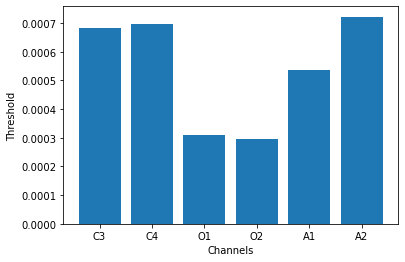

In [21]:
plt.figure()
plt.bar(range(len(threshes.keys())), threshes.values())
plt.xticks(range(len(threshes.keys())), threshes.keys())
plt.xlabel("Channels")
plt.ylabel("Threshold")
plt.show()

In [25]:
# dataset.epochs.drop_bad(reject=threshes)

In [22]:
# from autoreject import set_matplotlib_defaults
# set_matplotlib_defaults(plt)

# unit = r'fT/cm'
# scaling = 1e13

# plt.figure(figsize=(6, 5))
# plt.tick_params(axis='x', which='both', bottom='off', top='off')
# plt.tick_params(axis='y', which='both', left='off', right='off')

# plt.hist(scaling * np.array(list(threshes.values())), 30,
#          color='g', alpha=0.4)
# plt.xlabel('Threshold (%s)' % unit)
# plt.ylabel('Number of sensors')
# plt.xlim((100, 950))
# plt.tight_layout()
# plt.show()